In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import joblib

In [ ]:
# Load dataset
df = pd.read_csv('health_emergencies.csv')
df.columns = [c.strip() for c in df.columns]

In [ ]:
df.head()

,Date,Year,Time,Day_of_Week,Barangay,Latitude,Longitude,Weather,Health_Type,Health_Cause,Severity,Patient_Count,Response_Time,Treatment_Time
0,23/11/2025,2025,13:14,Thursday,San Mateo (Imok),14.089903,121.333461,Foggy,Allergic Reaction,Infection,High,3,12,43
1,07/05/2022,2022,13:58,Tuesday,V-C,14.106827,121.282542,Stormy,Fall,Chronic Illness,Low,3,12,39
2,30/09/2024,2024,15:47,Monday,V-B,14.080581,121.274854,Rainy,Burn,Accident,Medium,2,20,28
3,07/10/2021,2021,12:03,Sunday,San Gregorio,14.031415,121.299749,Sunny,Burn,Other,Medium,1,9,13
4,11/10/2025,2025,20:19,Sunday,San Antonio 1 (Balanga),14.012716,121.348980,Sunny,Allergic Reaction,Allergy,High,1,14,27


In [ ]:
df.shape

(1500, 14)

In [ ]:
df.columns

Index(['Date', 'Year', 'Time', 'Day_of_Week', 'Barangay', 'Latitude',
       'Longitude', 'Weather', 'Health_Type', 'Health_Cause', 'Severity',
       'Patient_Count', 'Response_Time', 'Treatment_Time'],
      dtype='object')

In [ ]:
# Handle missing values
df = df.dropna(subset=['Year', 'Barangay', 'Health_Type', 'Health_Cause', 'Severity'])

In [ ]:
# Define features and target
X = df[['Year', 'Barangay', 'Health_Type', 'Health_Cause']]
y = df['Severity'].apply(lambda x: 1 if x in ['Medium', 'High'] else 0)  # 1 for severe, 0 for low

In [ ]:
# Preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['Year']),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False),
         ['Barangay', 'Health_Type', 'Health_Cause'])
    ],
    remainder='drop'
)

In [ ]:
# Random Forest pipeline
pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(
        n_estimators=400,
        max_depth=15,
        min_samples_split=5,
        min_samples_leaf=2,
        random_state=42,
        n_jobs=-1
    ))
])

In [ ]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42, stratify=y)

In [ ]:
# Train model
pipe.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['Year']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['Barangay', 'Health_Type',
                                                   'Health_Cause'])])),
                ('classifier',
                 RandomForestClassifier(max_depth=15, min_samples_leaf=2,
                                        min_samples_split=5, n_estimators=400,
                                        n_jobs=-1, random_state=42))])

In [ ]:
# Make predictions
y_pred = pipe.predict(X_test)
y_proba = pipe.predict_proba(X_test)[:, 1]

In [ ]:
print("=== Random Forest - Classification Report ===")
print(classification_report(y_test, y_pred, digits=4))

=== Random Forest - Classification Report ===
              precision    recall  f1-score   support

           0     0.4286    0.0414    0.0755       145
           1     0.6812    0.9738    0.8016       305

    accuracy                         0.6733       450
   macro avg     0.5549    0.5076    0.4385       450
weighted avg     0.5998    0.6733    0.5676       450



=== Random Forest - Confusion Matrix ===
[[  6 139]
 [  8 297]]


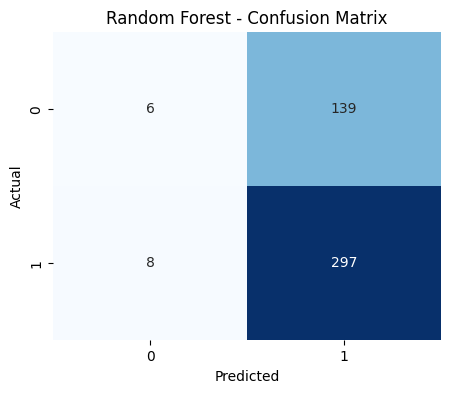

In [ ]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print("=== Random Forest - Confusion Matrix ===")
print(cm)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title("Random Forest - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

=== Random Forest - ROC AUC: 0.5539 ===


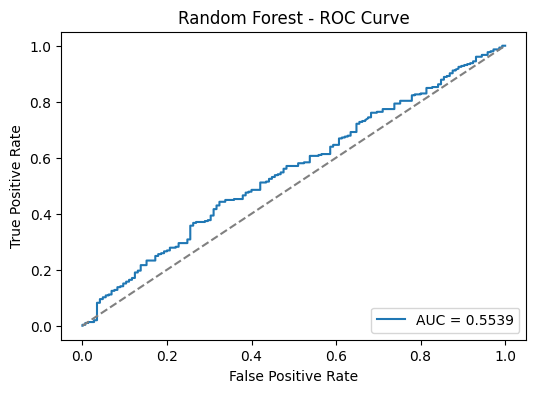

In [ ]:
# ROC Curve
y_proba = pipe.predict_proba(X_test)[:,1]
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)
print(f"=== Random Forest - ROC AUC: {roc_auc:.4f} ===")
plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.4f}")
plt.plot([0,1],[0,1],'--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Random Forest - ROC Curve")
plt.legend(loc='lower right')
plt.show()

In [ ]:
# Save model
joblib.dump(pipe, "health_predictor_rf.pkl")
print("Saved model to health_predictor_rf.pkl")

Saved model to health_predictor_rf.pkl
